Isotropic Total Variation (ADMM)
================================

This example compares denoising via isotropic and anisotropic total
variation (TV) regularization <cite data-cite="rudin-1992-nonlinear"/>
<cite data-cite="goldstein-2009-split"/>. It solves the denoising problem

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - \mathbf{x}
  \|_2^2 + \lambda R(\mathbf{x}) \;,$$

where $R$ is either the isotropic or anisotropic TV regularizer.
In SCICO, switching between these two regularizers is a one-line
change: replacing an
[L1Norm](../_autosummary/scico.functional.rst#scico.functional.L1Norm)
with a
[L21Norm](../_autosummary/scico.functional.rst#scico.functional.L21Norm).
Note that the isotropic version exhibits fewer block-like artifacts on
edges that are not vertical or horizontal.

In [1]:
import jax

from xdesign import SiemensStar, discrete_phantom

import scico.numpy as snp
import scico.random
from scico import functional, linop, loss, plot
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 256  # image size
phantom = SiemensStar(16)
x_gt = snp.pad(discrete_phantom(phantom, 240), 8)
x_gt = jax.device_put(x_gt)  # convert to jax type, push to GPU
x_gt = x_gt / x_gt.max()

Add noise to create a noisy test image.

In [3]:
σ = 0.75  # noise standard deviation
noise, key = scico.random.randn(x_gt.shape, seed=0)
y = x_gt + σ * noise

Denoise with isotropic total variation.

In [4]:
λ_iso = 1.4e0
f = loss.SquaredL2Loss(y=y)
g_iso = λ_iso * functional.L21Norm()

# The append=0 option makes the results of horizontal and vertical finite
# differences the same shape, which is required for the L21Norm.
C = linop.FiniteDifference(input_shape=x_gt.shape, append=0)
solver = ADMM(
    f=f,
    g_list=[g_iso],
    C_list=[C],
    rho_list=[1e1],
    x0=y,
    maxiter=100,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-3, "maxiter": 20}),
    itstat_options={"display": True, "period": 10},
)

print(f"Solving on {device_info()}\n")
solver.solve()
x_iso = solver.x
print()

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  2.03e+00  1.082e+05  3.575e+01  7.402e+01      0  0.000e+00


  10  2.88e+00  3.817e+04  5.134e+00  4.425e+01     12  8.275e-04


  20  3.13e+00  2.207e+04  3.056e+00  1.395e+01     15  9.808e-04


  30  3.29e+00  2.106e+04  8.046e-01  2.882e+00     12  8.529e-04
  40  3.41e+00  2.103e+04  3.130e-01  5.875e-01      8  8.282e-04


  50  3.50e+00  2.103e+04  2.025e-01  1.988e-01      6  9.583e-04
  60  3.57e+00  2.104e+04  1.579e-01  1.151e-01      5  9.939e-04
  70  3.63e+00  2.104e+04  1.311e-01  7.801e-02      2  8.910e-04


  80  3.69e+00  2.104e+04  1.130e-01  5.143e-02      1  9.950e-04
  90  3.74e+00  2.105e+04  9.686e-02  5.077e-02      2  8.297e-04
  99  3.79e+00  2.105e+04  8.759e-02  4.180e-02      3  9.270e-04



Denoise with anisotropic total variation for comparison.

In [5]:
# Tune the weight to give the same data fidelty as the isotropic case.
λ_aniso = 1.2e0
g_aniso = λ_aniso * functional.L1Norm()

solver = ADMM(
    f=f,
    g_list=[g_aniso],
    C_list=[C],
    rho_list=[1e1],
    x0=y,
    maxiter=100,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-3, "maxiter": 20}),
    itstat_options={"display": True, "period": 10},
)

solver.solve()
x_aniso = solver.x
print()

Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  2.54e-01  1.163e+05  4.213e+01  8.515e+01      0  0.000e+00
  10  5.03e-01  3.603e+04  6.953e+00  4.430e+01     13  8.779e-04


  20  6.59e-01  2.176e+04  3.025e+00  1.185e+01     15  9.150e-04


  30  8.00e-01  2.104e+04  7.598e-01  2.619e+00     11  8.676e-04
  40  9.05e-01  2.102e+04  3.102e-01  6.458e-01      7  9.297e-04
  50  9.86e-01  2.102e+04  1.982e-01  3.068e-01      3  8.806e-04


  60  1.05e+00  2.102e+04  1.502e-01  1.978e-01      6  8.621e-04
  70  1.11e+00  2.102e+04  1.216e-01  1.372e-01      2  8.452e-04
  80  1.17e+00  2.103e+04  1.007e-01  9.945e-02      2  6.335e-04


  90  1.22e+00  2.103e+04  8.784e-02  6.581e-02      1  9.096e-04
  99  1.27e+00  2.103e+04  7.687e-02  5.576e-02      1  8.235e-04



Compute and print the data fidelity.

In [6]:
for x, name in zip((x_iso, x_aniso), ("Isotropic", "Anisotropic")):
    df = f(x)
    print(f"Data fidelity for {name} TV was {df:.2e}")

Data fidelity for Isotropic TV was 1.86e+04
Data fidelity for Anisotropic TV was 1.86e+04


Plot results.

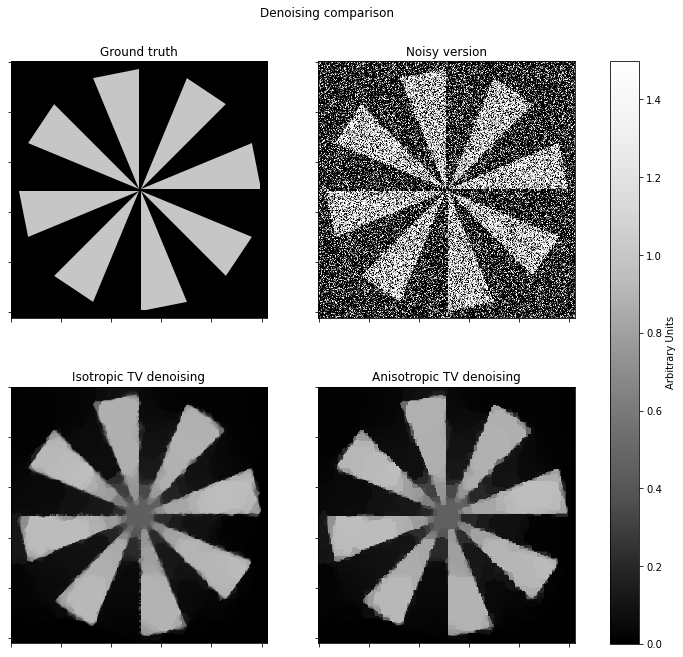

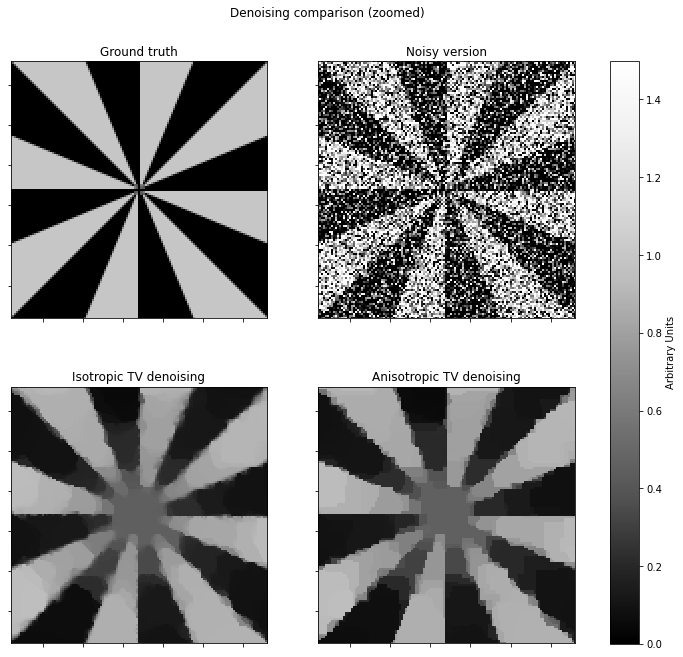

In [7]:
plt_args = dict(norm=plot.matplotlib.colors.Normalize(vmin=0, vmax=1.5))
fig, ax = plot.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(11, 10))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0, 0], **plt_args)
plot.imview(y, title="Noisy version", fig=fig, ax=ax[0, 1], **plt_args)
plot.imview(x_iso, title="Isotropic TV denoising", fig=fig, ax=ax[1, 0], **plt_args)
plot.imview(x_aniso, title="Anisotropic TV denoising", fig=fig, ax=ax[1, 1], **plt_args)
fig.subplots_adjust(left=0.1, right=0.99, top=0.95, bottom=0.05, wspace=0.2, hspace=0.01)
fig.colorbar(
    ax[0, 0].get_images()[0], ax=ax, location="right", shrink=0.9, pad=0.05, label="Arbitrary Units"
)
fig.suptitle("Denoising comparison")
fig.show()

# zoomed version
fig, ax = plot.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(11, 10))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0, 0], **plt_args)
plot.imview(y, title="Noisy version", fig=fig, ax=ax[0, 1], **plt_args)
plot.imview(x_iso, title="Isotropic TV denoising", fig=fig, ax=ax[1, 0], **plt_args)
plot.imview(x_aniso, title="Anisotropic TV denoising", fig=fig, ax=ax[1, 1], **plt_args)
ax[0, 0].set_xlim(N // 4, N // 4 + N // 2)
ax[0, 0].set_ylim(N // 4, N // 4 + N // 2)
fig.subplots_adjust(left=0.1, right=0.99, top=0.95, bottom=0.05, wspace=0.2, hspace=0.01)
fig.colorbar(
    ax[0, 0].get_images()[0], ax=ax, location="right", shrink=0.9, pad=0.05, label="Arbitrary Units"
)
fig.suptitle("Denoising comparison (zoomed)")
fig.show()